# Integrating BayesFlow Likelihood Ratio Estimation into HSSM

This tutorial demonstrates how to use a trained [BayesFlow](https://github.com/bayesflow-org/bayesflow) `RatioApproximator` as a custom likelihood within HSSM. 

**Background.** BayesFlow's *Likelihood Ratio Estimation* (LRE) trains a neural classifier to approximate the log-likelihood-to-evidence ratio for a simulator-based model. Once trained, this approximator produces a differentiable, pure-JAX function that can serve as a drop-in likelihood for MCMC sampling.

HSSM already provides all the infrastructure to turn an arbitrary JAX callable into a fully functional PyMC distribution with gradient support. This tutorial shows two ways to make the connection:

1. **Low-level approach** -- use HSSM's distribution utilities (`make_jax_logp_funcs_from_callable`, `make_jax_logp_ops`, `make_distribution`) to build a raw PyMC model.
2. **High-level approach** -- pass the JAX callable directly to the `hssm.HSSM()` class with `loglik_kind="approx_differentiable"`, letting HSSM handle all the plumbing.

We will use the standard Drift Diffusion Model (DDM) throughout.

## Colab Instructions

If you would like to run this tutorial on Google Colab, uncomment and run the installation cell below, then **restart your runtime**.

You may want to switch your runtime to GPU/TPU for faster training. Go to *Runtime* > *Change runtime type*.

In [1]:
# Uncomment below if running on Colab
# !pip install hssm[bayesflow]

---
## Part 1: Setup

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import hssm
from hssm.config import ModelConfig
from ssms.basic_simulators.simulator import simulator as ssm_simulator
from ssms.config import model_config as ssms_model_config

try:
    import bayesflow as bf
    import keras
except ImportError:
    raise ImportError(
        "This tutorial requires bayesflow and keras. "
        "Install them with:  pip install hssm[bayesflow]"
    )

print(f"Keras backend : {keras.backend.backend()}")
print(f"JAX devices   : {jax.devices()}")

INFO:2026-02-28 18:18:59,636:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2026-02-28 18:18:59,638:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no su

Keras backend : jax
JAX devices   : [CpuDevice(id=0)]


In [3]:
LOAD_PRETRAINED = True
SAVE_DIR = os.path.join("data", "bayesflow_models")
PRE_TRAINED_NAME = "ddm_ratio_approximator.keras"

---
## Part 2: Simulate Observed DDM Data

We simulate a dataset from a DDM with known ground-truth parameters. This is the data we will later try to recover via MCMC.

In [4]:
TRUE_PARAMS = dict(v=0.5, a=1.25, z=0.5, t=0.2)
N_OBS = 500
SEED = 42

obs_data = hssm.simulate_data(
    model="ddm",
    theta=TRUE_PARAMS,
    size=N_OBS,
    random_state=SEED,
)

obs_data.head()

,rt,response
0,0.962074,-1.0
1,0.998047,1.0
2,1.067681,1.0
3,0.554913,-1.0
4,1.660933,1.0


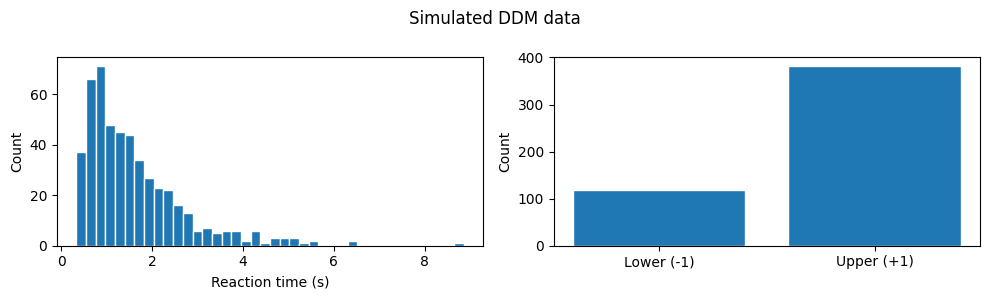

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(obs_data["rt"], bins=40, edgecolor="white")
axes[0].set_xlabel("Reaction time (s)")
axes[0].set_ylabel("Count")
axes[1].bar(
    ["Lower (-1)", "Upper (+1)"],
    obs_data["response"].value_counts().sort_index().values,
    edgecolor="white",
)
axes[1].set_ylabel("Count")
fig.suptitle("Simulated DDM data")
plt.tight_layout()

---
## Part 3: Train (or Load) a BayesFlow RatioApproximator

We first set up a BayesFlow generative model that pairs uniform priors over the DDM parameter bounds with the `ssm-simulators` simulator. Then we train a `RatioApproximator` to estimate the log-likelihood-to-evidence ratio.

If `LOAD_PRETRAINED = True`, the training is skipped and a saved model is loaded from disk.

### DDM configuration

In [6]:
ddm_cfg = ssms_model_config["ddm"]
param_names = ddm_cfg["params"]
param_lower = np.array(ddm_cfg["param_bounds"][0])
param_upper = np.array(ddm_cfg["param_bounds"][1])

print("DDM parameters:")
for name, lo, hi in zip(param_names, param_lower, param_upper):
    print(f"  {name:5s}: bounds=[{lo:5.2f}, {hi:5.2f}]")

DDM parameters:
  v    : bounds=[-3.00,  3.00]
  a    : bounds=[ 0.30,  2.50]
  z    : bounds=[ 0.10,  0.90]
  t    : bounds=[ 0.00,  2.00]


### BayesFlow generative model

In [7]:
def prior():
    params = {}
    for name, lo, hi in zip(param_names, param_lower, param_upper):
        params[name] = np.random.uniform(lo, hi)
    return params


def likelihood(v, a, z, t):
    result = ssm_simulator(
        theta={"v": v, "a": a, "z": z, "t": t},
        model="ddm",
        n_samples=1,
        delta_t=0.001,
    )
    rt = float(result["rts"].flat[0])
    choice = float(result["choices"].flat[0])
    return {"obs": np.array([rt, choice], dtype=np.float32)}


simulator = bf.make_simulator([prior, likelihood])

### Build, train, and save

In [8]:
if not LOAD_PRETRAINED:
    adapter = bf.approximators.RatioApproximator.build_adapter(
        inference_variables=["v", "a", "z", "t"],
        inference_conditions=["obs"],
    )

    ratio_approximator = bf.approximators.RatioApproximator(
        adapter=adapter,
        classifier_network=bf.networks.MLP(widths=[256, 256, 256]),
        standardize=None,
    )

    ratio_approximator.compile(optimizer="adam")
    history = ratio_approximator.fit(
        simulator=simulator,
        epochs=150,
        num_batches=200,
        batch_size=64,
    )

    bf.diagnostics.plots.loss(history)

    os.makedirs(SAVE_DIR, exist_ok=True)
    ratio_approximator.save(os.path.join(SAVE_DIR, PRE_TRAINED_NAME))
    print(f"Saved to {SAVE_DIR}/{PRE_TRAINED_NAME}")
else:
    print("Skipping training (LOAD_PRETRAINED = True).")

Skipping training (LOAD_PRETRAINED = True).


### Load pre-trained model

In [9]:
if LOAD_PRETRAINED:
    load_path = os.path.join(SAVE_DIR, PRE_TRAINED_NAME)
    ratio_approximator = keras.saving.load_model(load_path)
    print(f"Loaded from: {load_path}")
else:
    print("Using in-memory approximator from training above.")

Loaded from: data/bayesflow_models/ddm_ratio_approximator.keras


---
## Part 4: Extract a JAX Single-Trial Function

The trained `RatioApproximator` is a Keras model. We extract a **pure JAX function** with the signature:

```
f(obs_i, v, a, z, t) -> scalar log_ratio
```

where `obs_i` is a length-2 array `[rt, choice]` and the parameters are scalars. This is the function we will plug into HSSM.

In [10]:
def make_jax_log_ratio_fn(ratio_approximator):
    """Extract a pure JAX single-trial log-ratio callable.

    Returns
    -------
    Callable
        f(obs_i, v, a, z, t) -> scalar log_ratio
        where obs_i is shape (2,) = [rt, choice] and params are scalars.
    """
    classifier = ratio_approximator.classifier_network
    projector = ratio_approximator.projector

    std_layers = getattr(ratio_approximator, "standardize_layers", None) or {}
    std_keys = getattr(ratio_approximator, "standardize", None) or []

    def single_trial_log_ratio(obs_i, *params):
        inf_vars = jnp.array([jnp.squeeze(p) for p in params])
        inf_conds = jnp.atleast_1d(obs_i)

        if "inference_variables" in std_keys and "inference_variables" in std_layers:
            inf_vars = std_layers["inference_variables"](
                inf_vars[None, :], training=False
            )[0]
        if "inference_conditions" in std_keys and "inference_conditions" in std_layers:
            inf_conds = std_layers["inference_conditions"](
                inf_conds[None, :], training=False
            )[0]

        classifier_input = jnp.concatenate([inf_vars, inf_conds])
        hidden = classifier(classifier_input[None, :], training=False)
        logits = projector(hidden, training=False)
        return jnp.squeeze(logits).astype(jnp.float64)

    return single_trial_log_ratio


single_trial_fn = make_jax_log_ratio_fn(ratio_approximator)

In [11]:
test_obs = jnp.array([0.8, 1.0])
test_val = single_trial_fn(
    test_obs,
    jnp.array(0.5),
    jnp.array(1.0),
    jnp.array(0.5),
    jnp.array(0.3),
)
print(
    f"Single trial log-ratio at "
    f"(obs=[0.8, 1.0], v=0.5, a=1.0, z=0.5, t=0.3): {test_val:.4f}"
)

Single trial log-ratio at (obs=[0.8, 1.0], v=0.5, a=1.0, z=0.5, t=0.3): 1.5784


---
## Part 5: Low-Level Integration via HSSM Distribution Utilities

This section shows how to manually wire the BayesFlow JAX function into a raw PyMC model using HSSM's distribution utility functions. This is useful if you need fine-grained control over the model specification.

The pipeline has four steps:

| Step | HSSM utility | Purpose |
|------|-------------|---------|
| A | `make_jax_logp_funcs_from_callable` | Vectorize (vmap) over trials + compute VJP for gradients |
| B | `make_jax_logp_ops` | Wrap JAX functions in PyTensor Ops with gradient support |
| C | `make_distribution` | Create a `pm.Distribution` with bounds checking and NDT validation |
| D | `pm.Model` | Build and sample from a standard PyMC model |

In [12]:
from hssm.distribution_utils.dist import make_distribution
from hssm.distribution_utils.jax import (
    make_jax_logp_funcs_from_callable,
    make_jax_logp_ops,
)

### Step A: Vectorize + VJP

In [13]:
logp_jit, logp_vjp_jit, logp_nojit = make_jax_logp_funcs_from_callable(
    single_trial_fn,
    vmap=True,
    params_is_reg=[True, True, True, True],
)
print("Vectorized + VJP functions created.")

params_only:  False
params_is_reg:  [True, True, True, True]
Vectorized + VJP functions created.


### Step B: PyTensor Ops

In [14]:
ratio_op = make_jax_logp_ops(logp_jit, logp_vjp_jit, logp_nojit)
print(f"PyTensor Op created: {ratio_op}")

PyTensor Op created: LANLogpOp


### Step C: Create `pm.Distribution`

In [15]:
ddm_bounds = {
    "v": (-3.0, 3.0),
    "a": (0.3, 2.5),
    "z": (0.1, 0.9),
    "t": (0.0, 2.0),
}

DDMRatioDistribution = make_distribution(
    rv="ddm",
    loglik=ratio_op,
    list_params=["v", "a", "z", "t"],
    bounds=ddm_bounds,
    params_is_trialwise=[True, True, True, True],
)

print(f"pm.Distribution: {DDMRatioDistribution}")

pm.Distribution: <class 'hssm.distribution_utils.dist.make_distribution.<locals>.HSSMDistribution'>


### Step D: PyMC Model + NUTS Sampling

Since all parameters are marked as `params_is_reg=True` (trial-wise), we broadcast scalar priors to vectors of length `n_obs` via a `Deterministic` node.

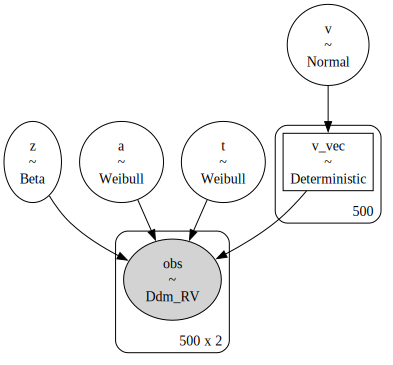

In [16]:
observed = obs_data[["rt", "response"]].values
n_obs = observed.shape[0]

with pm.Model() as model_lowlevel:
    v = pm.Normal("v", mu=0, sigma=1)
    a = pm.Weibull("a", alpha=2.0, beta=1.2)
    z = pm.Beta("z", alpha=10, beta=10)
    t = pm.Weibull("t", alpha=1.5, beta=0.5)

    v_vec = pm.Deterministic("v_vec", v * pt.ones(n_obs))

    DDMRatioDistribution(
        "obs",
        observed=observed,
        v=v_vec,
        a=a,
        z=z,
        t=t,
    )

pm.model_to_graphviz(model_lowlevel)

In [17]:
with model_lowlevel:
    idata_lowlevel = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        nuts_sampler="numpyro",
    )

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1000/1000 [00:20<00:00, 49.74it/s, 7 steps of size 4.71e-01. acc. prob=0.92]
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [18]:
az.summary(idata_lowlevel, var_names=["v", "a", "z", "t"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.495,0.046,0.418,0.586,0.002,0.001,689.0,648.0,1.0
a,1.254,0.030,1.201,1.310,0.001,0.001,684.0,552.0,1.0
z,0.539,0.017,0.508,0.571,0.001,0.001,615.0,496.0,1.0
t,0.230,0.017,0.199,0.262,0.001,0.001,716.0,571.0,1.0


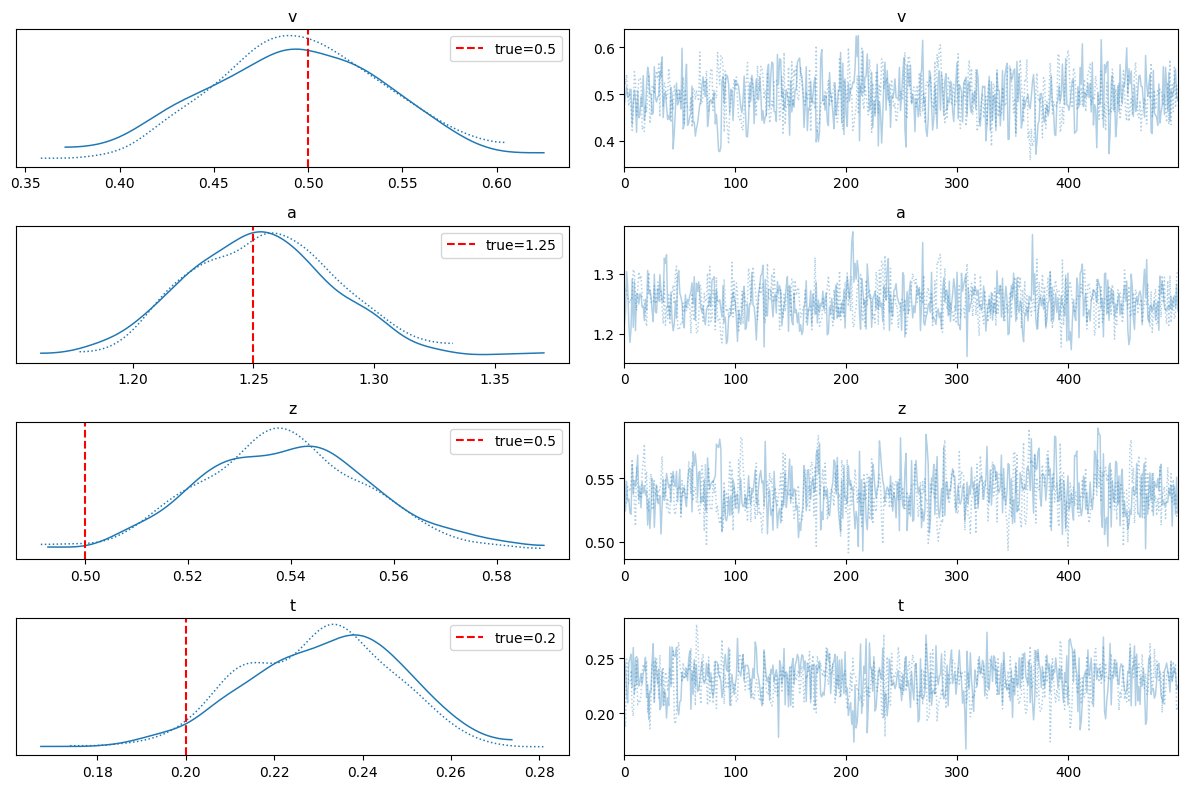

In [19]:
axes = az.plot_trace(
    idata_lowlevel, var_names=["v", "a", "z", "t"], figsize=(12, 8)
)

for ax_row, (name, true_val) in zip(axes, TRUE_PARAMS.items()):
    ax_row[0].axvline(true_val, color="red", linestyle="--", label=f"true={true_val}")
    ax_row[0].legend()

plt.tight_layout()

---
## Part 6: High-Level Integration via `hssm.HSSM()`

The low-level approach is instructive but involves several manual steps. HSSM's `HSSM()` class can handle all of this automatically when you pass a JAX callable as the `loglik` argument with `loglik_kind="approx_differentiable"`.

This is the **recommended approach** for most users.

In [20]:
lre_model_config = ModelConfig(
    response=["rt", "response"],
    list_params=["v", "a", "z", "t"],
    choices=(-1, 1),
    bounds={
        "v": (-3.0, 3.0),
        "a": (0.3, 2.5),
        "z": (0.1, 0.9),
        "t": (0.0, 2.0),
    },
    backend="jax",
)

In [21]:
model_hssm = hssm.HSSM(
    data=obs_data,
    model="ddm",
    model_config=lre_model_config,
    loglik_kind="approx_differentiable",
    loglik=single_trial_fn,
    p_outlier=0,
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


params_only:  False
params_is_reg:  [True, False, False, False]
Model initialized successfully.


INFO:hssm:Model initialized successfully.


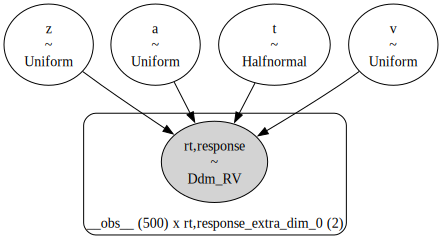

In [22]:
model_hssm.graph()

In [23]:
idata_hssm = model_hssm.sample(
    sampler="numpyro",
    draws=500,
    tune=500,
    chains=2,
    mp_ctx="spawn",
)

Using default initvals. 



INFO:hssm:Using default initvals. 

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1000/1000 [00:20<00:00, 48.61it/s, 7 steps of size 5.29e-01. acc. prob=0.92] 
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
100%|██████████| 1000/1000 [00:01<00:00, 739.56it/s]


In [24]:
az.summary(idata_hssm, var_names=["v", "a", "z", "t"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.497,0.044,0.420,0.585,0.002,0.001,518.0,670.0,1.00
a,1.253,0.030,1.201,1.311,0.001,0.001,687.0,747.0,1.00
z,0.538,0.017,0.508,0.569,0.001,0.000,495.0,546.0,1.01
t,0.230,0.018,0.198,0.264,0.001,0.001,618.0,526.0,1.00


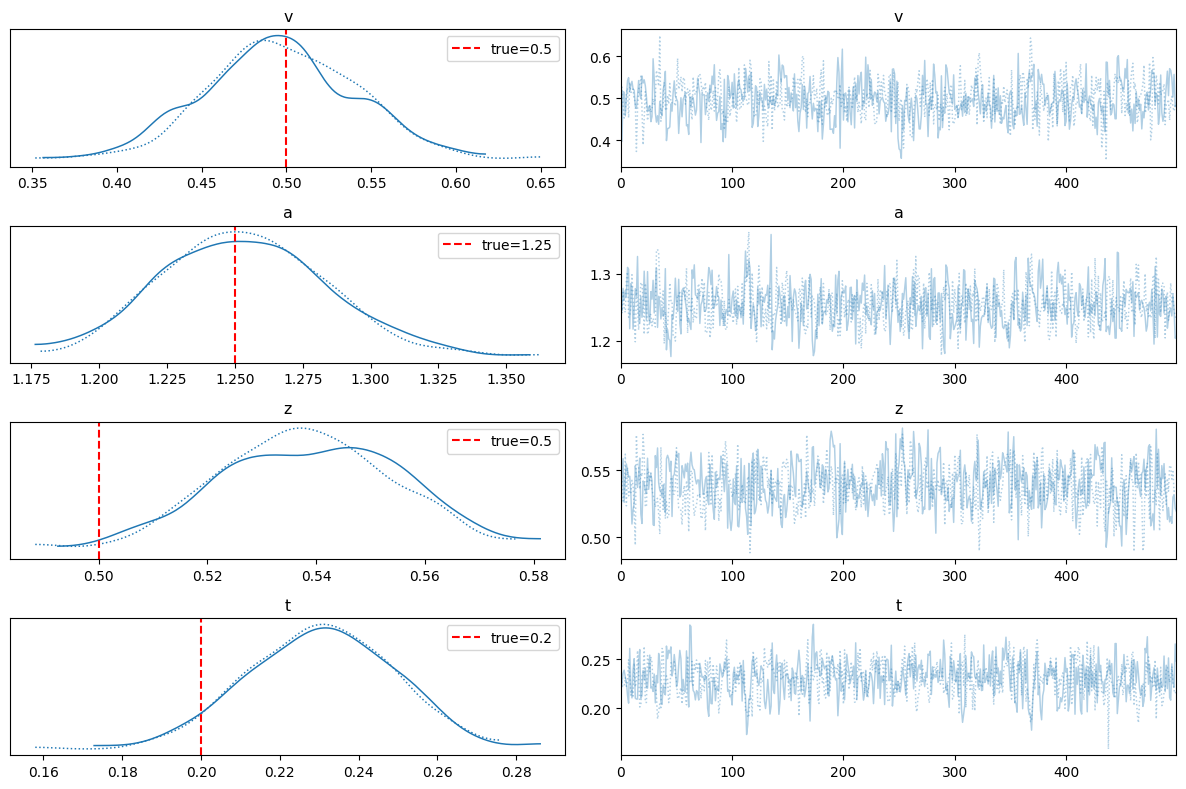

In [25]:
axes = az.plot_trace(
    idata_hssm, var_names=["v", "a", "z", "t"], figsize=(12, 8)
)

for ax_row, (name, true_val) in zip(axes, TRUE_PARAMS.items()):
    ax_row[0].axvline(true_val, color="red", linestyle="--", label=f"true={true_val}")
    ax_row[0].legend()

plt.tight_layout()

---
## Part 7: Comparison

Both approaches should yield equivalent posterior estimates. Let's compare them side by side.

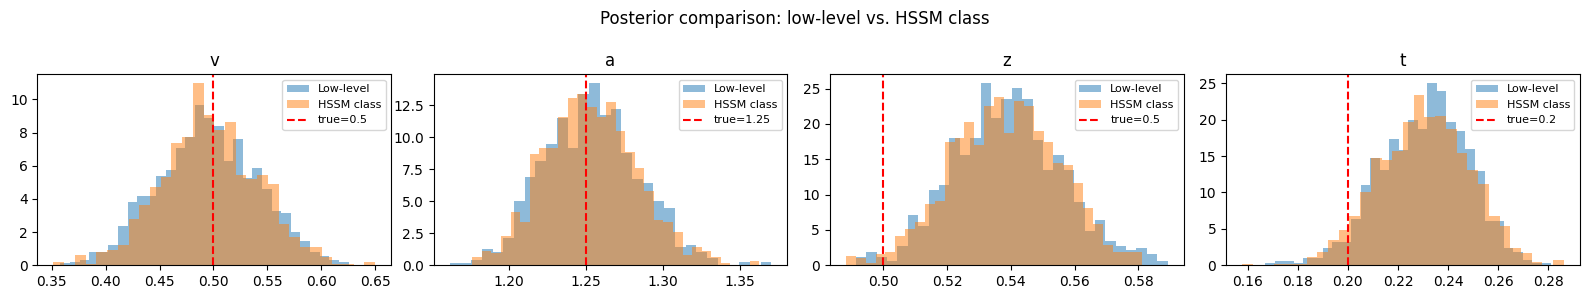

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for ax, param in zip(axes, ["v", "a", "z", "t"]):
    samples_ll = idata_lowlevel.posterior[param].values.flatten()
    samples_hssm = idata_hssm.posterior[param].values.flatten()

    ax.hist(samples_ll, bins=30, alpha=0.5, density=True, label="Low-level")
    ax.hist(samples_hssm, bins=30, alpha=0.5, density=True, label="HSSM class")
    ax.axvline(
        TRUE_PARAMS[param], color="red", linestyle="--",
        label=f"true={TRUE_PARAMS[param]}",
    )
    ax.set_title(param)
    ax.legend(fontsize=8)

fig.suptitle("Posterior comparison: low-level vs. HSSM class")
plt.tight_layout()

---
## END